In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pprint import pprint

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_weights_APR_FEB_hive1.csv
/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_temperatures_APR_FEB_hive1.csv
/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_humidity_APR_FEB_hive1.csv
/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_carbondioxide_APR_FEB_hive1.csv


In [35]:
# Load the data and set the 'created_at' column as the index
carbondioxide = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_carbondioxide_APR_FEB_hive1.csv', index_col='created_at')
humidity = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_humidity_APR_FEB_hive1.csv', index_col='created_at')
temperatures = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_temperatures_APR_FEB_hive1.csv', index_col='created_at')
weights = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_weights_APR_FEB_hive1.csv', index_col='created_at')

# Convert the index to datetime
carbondioxide.index = pd.to_datetime(carbondioxide.index)
humidity.index = pd.to_datetime(humidity.index)
temperatures.index = pd.to_datetime(temperatures.index)
weights.index = pd.to_datetime(weights.index)


# Check for and remove duplicates in the index
humidity = humidity[~humidity.index.duplicated(keep='first')]
carbondioxide = carbondioxide[~carbondioxide.index.duplicated(keep='first')]
temperatures = temperatures[~temperatures.index.duplicated(keep='first')]
weights = weights[~weights.index.duplicated(keep='first')]

In [36]:
#Cleaning the humidity data
# Replace '*2*' with a comma in the 'record' column
humidity['record'] = humidity['record'].str.replace('*2*', ',', regex=False)

# Split the 'record' column and assign to new columns
humidity[['Interior (%)', 'Exterior (%)']] = humidity['record'].str.split(',', expand=True)

# Drop the 'record' column as it's no longer needed
humidity = humidity.drop(columns=['record'])

# Convert new columns to numeric types
humidity['Interior (%)'] = pd.to_numeric(humidity['Interior (%)'], errors='coerce')
humidity['Exterior (%)'] = pd.to_numeric(humidity['Exterior (%)'], errors='coerce')

# Replace values of 2 with NaN (without inplace to avoid warnings)
humidity['Interior (%)'] = humidity['Interior (%)'].replace(2, np.nan)
humidity['Exterior (%)'] = humidity['Exterior (%)'].replace(2, np.nan)

# Display the resulting DataFrame
humidity.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Interior (%),Exterior (%)
created_at,,
2024-04-03 17:08:06,94.2,84.3
2024-04-03 23:10:57,93.2,91.9
2024-04-04 05:13:54,98.4,86.6
2024-04-04 11:17:07,88.6,70.6
2024-04-16 15:14:21,NaN,76.4


In [37]:
#Cleaning the CO2 data
#replacing 2 with NaN
carbondioxide['record'] = carbondioxide.record.replace(2, np.nan)
carbondioxide.head()

,record
created_at,
2024-04-03 17:08:06,7330.0
2024-04-03 23:10:57,6237.0
2024-04-04 05:13:54,1475.0
2024-04-04 11:17:07,195.0
2024-04-16 15:14:21,231.0


In [38]:
#Cleaning the weights data, replacing the 2 with NaN
weights.record = weights.record.replace(2, np.nan)
weights.head()

,record
created_at,
2024-04-03 17:08:06,15.0
2024-04-03 23:10:57,15.0
2024-04-04 05:13:54,15.0
2024-04-04 11:17:07,15.0
2024-04-16 15:14:21,15.0


In [39]:
#Cleaning the temperature data
# Replace '*2*' with a comma in the 'record' column
temperatures['record'] = temperatures['record'].str.replace('*2*', ',', regex=False)

# Split the 'record' column and assign to new columns
temperatures[['Interior (°C)', 'Exterior (°C)']] = temperatures['record'].str.split(',', expand=True)

# Drop the 'record' column as it's no longer needed
temperatures = temperatures.drop(columns=['record'])

# Convert new columns to numeric types
temperatures['Interior (°C)'] = pd.to_numeric(temperatures['Interior (°C)'], errors='coerce')
temperatures['Exterior (°C)'] = pd.to_numeric(temperatures['Exterior (°C)'], errors='coerce')

# Replace values of 2 with NaN (without inplace to avoid warnings)
temperatures['Interior (°C)'] = temperatures['Interior (°C)'].replace(2, np.nan)
temperatures['Exterior (°C)'] = temperatures['Exterior (°C)'].replace(2, np.nan)

# Display the resulting DataFrame
temperatures.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Interior (°C),Exterior (°C)
created_at,,
2024-04-03 17:08:06,27.3,23.9
2024-04-03 23:10:57,23.7,21.2
2024-04-04 05:13:54,25.3,22.2
2024-04-04 11:17:07,29.5,28.6
2024-04-16 15:14:21,NaN,26.7


In [40]:
# Remove NaN values from each DataFrame
carbondioxide.dropna(inplace=True)
humidity.dropna(inplace=True)
temperatures.dropna(inplace=True)
weights.dropna(inplace=True)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Step 1: Load and Prepare Data
def prepare_data(df):
    """
    Prepares the data by converting the index to datetime and adding Year and Month columns.
    """
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

# Step 2: Filter Data by Year and Month
def filter_data_by_month_year(df, year, month):
    """
    Filters the data for the specified year and month.
    """
    return df[(df['year'] == year) & (df['month'] == month)]

# Step 3: Basic CO₂ Statistics
def calculate_basic_statistics(df_filtered):
    """
    Calculates the basic statistics for CO₂ levels.
    """
    mean_co2 = round(df_filtered['record'].mean(), 2)
    median_co2 = round(df_filtered['record'].median(), 2)
    std_co2 = round(df_filtered['record'].std(), 2)
    min_co2 = round(df_filtered['record'].min(), 2)
    max_co2 = round(df_filtered['record'].max(), 2)
    
    return {
        "Mean CO₂": mean_co2,
        "Median CO₂": median_co2,
        "Standard Deviation": std_co2,
        "Min CO₂": min_co2,
        "Max CO₂": max_co2
    }

# Step 4: Diurnal Variation (Day vs. Night)
def calculate_diurnal_variation(df_filtered):
    """
    Calculates the average CO₂ for day (7:00-19:00) and night (19:00-7:00).
    """
    day_records = df_filtered.between_time("07:00", "18:59")
    night_records = df_filtered.between_time("19:00", "06:59")
    
    day_mean = round(day_records['record'].mean(), 2) if not day_records.empty else None
    night_mean = round(night_records['record'].mean(), 2) if not night_records.empty else None
    
    day_variability = round(day_records['record'].std(), 2) if not day_records.empty else None
    night_variability = round(night_records['record'].std(), 2) if not night_records.empty else None
    
    return {
        "Daytime Mean CO₂": day_mean,
        "Nighttime Mean CO₂": night_mean,
        "Daytime Variability": day_variability,
        "Nighttime Variability": night_variability
    }

# Step 5: Weekly Trend
def calculate_weekly_trend(df_filtered):
    """
    Calculates the weekly trend of CO₂ levels.
    """
    return df_filtered.resample('W')['record'].mean().round(2).to_dict()

# Step 6: Daily Trend
def calculate_daily_trend(df_filtered):
    """
    Calculates the daily trend of CO₂ levels.
    """
    return df_filtered.resample('D')['record'].mean().round(2).to_dict()

# Step 7: Anomaly Detection (Z-score)
def detect_anomalies(df_filtered, mean_co2, std_co2):
    """
    Detects anomalies based on Z-score method (Z-score > 2).
    """
    df_filtered['z_score'] = (df_filtered['record'] - mean_co2) / std_co2
    anomalies = df_filtered[np.abs(df_filtered['z_score']) > 2]
    return anomalies[['record']].to_dict(orient='records')

# Step 8: Format Results
def format_results(year, month, statistics, diurnal_variation, weekly_trend, daily_trend, anomalies):
    """
    Formats the results into a dictionary for output.
    """
    return {
        "Year": year,
        "Month": month,
        "Statistics": statistics,
        "Diurnal Variations": diurnal_variation,
        "Trends": {
            "Weekly Trend": weekly_trend,
            "Daily Trend": daily_trend
        },
        "Anomalies": anomalies
    }

# Step 9: Improved Plotting Functions

def plot_monthly_trend(df_filtered):
    """
    Plots the CO₂ trend over the month with improved layout.
    """
    plt.figure(figsize=(12, 6))  # Adjust the figure size for better clarity
    plt.plot(df_filtered.index, df_filtered['record'], color='b', linestyle='-', marker='o', markersize=4)  # Line plot with markers
    plt.title("CO₂ Levels Over the Month", fontsize=16, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("CO₂ (ppm)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines with style
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Ensures the labels are not cut off
    plt.show()

def plot_diurnal_variation(df_filtered):
    """
    Plots the boxplot for day vs night CO₂ levels.
    """
    # Add a column to classify the periods (Day or Night)
    df_filtered['period'] = ['Day' if 7 <= x.hour < 19 else 'Night' for x in df_filtered.index]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='period', y='record', data=df_filtered, palette="coolwarm")  # Using a palette for better contrast
    plt.title("Diurnal Variation of CO₂ Levels", fontsize=16, weight='bold')
    plt.xlabel("Period", fontsize=12)
    plt.ylabel("CO₂ Levels (ppm)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines with style
    plt.show()

# Step 10: CO₂ Analysis Pipeline
def analyze_co2_pipeline(df, year, month):
    """
    Full pipeline to analyze CO₂ data for a given month and year.
    """
    # Step 1: Prepare Data
    df = prepare_data(df)
    
    # Step 2: Filter Data by Year and Month
    df_filtered = filter_data_by_month_year(df, year, month)
    
    if df_filtered.empty:
        return f"No data available for {year}-{month:02d}"

    # Step 3: Basic Statistics
    statistics = calculate_basic_statistics(df_filtered)

    # Step 4: Diurnal Variation
    diurnal_variation = calculate_diurnal_variation(df_filtered)
    
    # Step 5: Weekly Trend
    weekly_trend = calculate_weekly_trend(df_filtered)

    # Step 6: Daily Trend
    daily_trend = calculate_daily_trend(df_filtered)

    # Step 7: Anomaly Detection
    anomalies = detect_anomalies(df_filtered, statistics["Mean CO₂"], statistics["Standard Deviation"])
    
    # Step 8: Format Results
    result = format_results(year, month, statistics, diurnal_variation, weekly_trend, daily_trend, anomalies)
    
    # Step 9: Plotting
    plot_monthly_trend(df_filtered)
    plot_diurnal_variation(df_filtered)

    # Pretty-print the result
    pprint(result, sort_dicts=False)


<ipython-input-55-bd830d96f736>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['z_score'] = (df_filtered['record'] - mean_co2) / std_co2


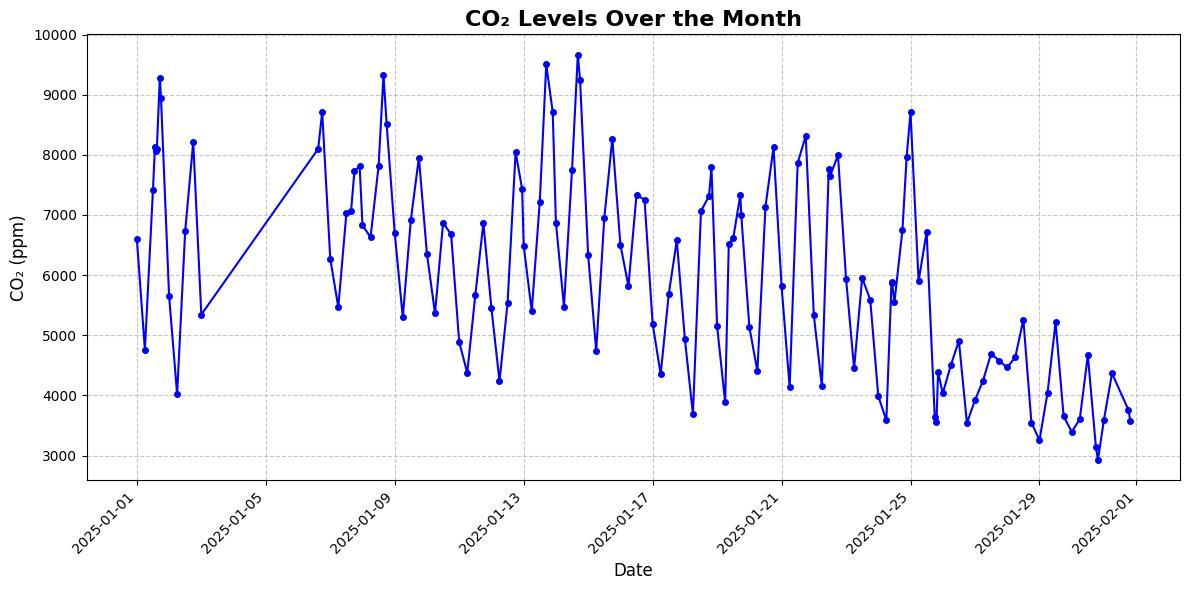

<ipython-input-55-bd830d96f736>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['period'] = ['Day' if 7 <= x.hour < 19 else 'Night' for x in df_filtered.index]


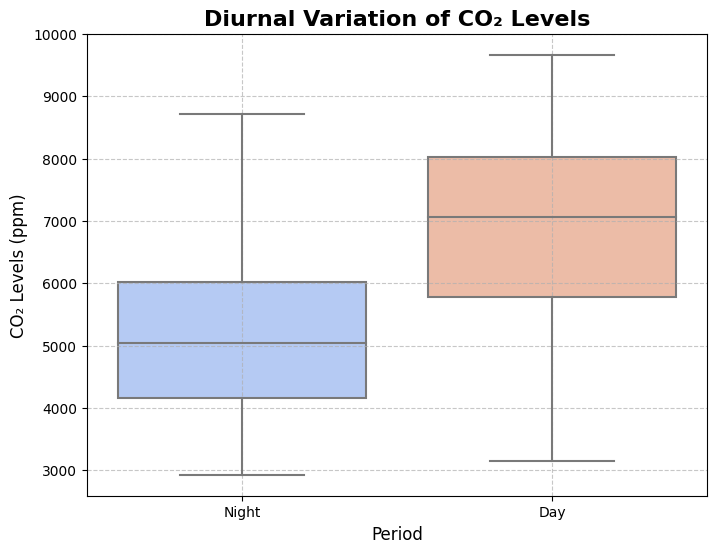

{'Year': 2025,
 'Month': 1,
 'Statistics': {'Mean CO₂': 6042.95,
                'Median CO₂': 5898.0,
                'Standard Deviation': 1697.42,
                'Min CO₂': 2927.0,
                'Max CO₂': 9666.0},
 'Diurnal Variations': {'Daytime Mean CO₂': 6846.84,
                        'Nighttime Mean CO₂': 5201.39,
                        'Daytime Variability': 1593.55,
                        'Nighttime Variability': 1370.54},
 'Trends': {'Weekly Trend': {Timestamp('2025-01-05 00:00:00'): 7019.38,
                             Timestamp('2025-01-12 00:00:00'): 6730.1,
                             Timestamp('2025-01-19 00:00:00'): 6625.79,
                             Timestamp('2025-01-26 00:00:00'): 5743.0,
                             Timestamp('2025-02-02 00:00:00'): 4026.62},
            'Daily Trend': {Timestamp('2025-01-01 00:00:00'): 7660.62,
                            Timestamp('2025-01-02 00:00:00'): 6155.75,
                            Timestamp('2025-01-03 00:00

In [56]:
results = analyze_co2_pipeline(carbondioxide, 2025, 1)
print(results)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

def analyze_weight_for_month_year(df, year, month):
    """
    Analyzes weight records for a given month and year.
    
    Parameters:
    - df: DataFrame with 'created_at' as the index (datetime format) and 'record' column for weight.
    - year: Integer representing the year to analyze.
    - month: Integer (1-12) representing the month to analyze.
    
    Returns:
    - A formatted dictionary with calculated insights.
    """
    # Ensure the index is in datetime format
    df.index = pd.to_datetime(df.index)

    # Add Year & Month columns for filtering
    df['year'] = df.index.year
    df['month'] = df.index.month

    # Filter data for the given year and month
    df_filtered = df[(df['year'] == year) & (df['month'] == month)]

    if df_filtered.empty:
        return f"No data available for {year}-{month:02d}"

    # Plot the monthly trend of weights with enhanced formatting
    plt.figure(figsize=(12, 6))  # Adjusted figure size for better clarity
    df_filtered['record'].plot(title=f"Weight Trend for {year}-{month:02d}", xlabel="Date", ylabel="Weight (kgs)", color='b', linestyle='-', marker='o', markersize=4)
    plt.grid(True, linestyle='--', alpha=0.7)  # Added gridlines with style
    plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better readability
    plt.tight_layout()  # Ensures the labels are not cut off
    plt.show()

    # Mean, Max, Min weight
    mean_weight = round(df_filtered['record'].mean(), 2)
    max_weight = round(df_filtered['record'].max(), 2)
    min_weight = round(df_filtered['record'].min(), 2)

    # Range of daily fluctuations
    daily_fluctuations = df_filtered.resample('D')['record'].agg(['min', 'max', 'mean'])
    daily_fluctuations['fluctuation_range'] = daily_fluctuations['max'] - daily_fluctuations['min']
    daily_fluctuations = daily_fluctuations[['fluctuation_range']].sort_values(by='fluctuation_range', ascending=False)

    # Comment on daily weight fluctuations
    significant_fluctuations = daily_fluctuations[daily_fluctuations['fluctuation_range'] > 1]  # Filter large fluctuations

    # Overall weight trend
    daily_trend = df_filtered.resample('D')['record'].mean()
    trend_summary = f"Overall, the weight shows a gradual increase from {daily_trend.iloc[0]:.2f} kg at the beginning of the month to {daily_trend.iloc[-1]:.2f} kg by mid-month. This suggests consistent resource gathering by the colony."

    # Hourly patterns (6:00-18:00 for daytime)
    hourly_trend = df_filtered.resample('H')['record'].mean()
    daytime_weight = hourly_trend.between_time("06:00", "17:59")
    nighttime_weight = hourly_trend.between_time("18:00", "05:59")
    day_mean_weight = round(daytime_weight.mean(), 2)
    night_mean_weight = round(nighttime_weight.mean(), 2)

    # Format the results
    result = {
        "Year": year,
        "Month": month,
        "Statistics": {
            "Maximum Weight": max_weight,
            "Minimum Weight": min_weight,
            "Mean Weight": mean_weight
        },
        "Daily Weight Fluctuations": {
            "Significant Fluctuations": significant_fluctuations.to_dict(orient='records'),
            "Fluctuations Summary": "Most days show small weight variations (0.1-0.3 kg)."
        },
        "Overall Weight Trend": trend_summary,
        "Hourly Patterns": {
            "Daytime Mean Weight": day_mean_weight,
            "Nighttime Mean Weight": night_mean_weight,
            "Hourly Patterns Summary": "The hourly analysis shows slight weight decreases during daytime hours (6:00-18:00), consistent with where bees leave the hive during daylight hours and return with resources in the evening."
        }
    }

    # Pretty-print the result
    pprint(result, sort_dicts=False)


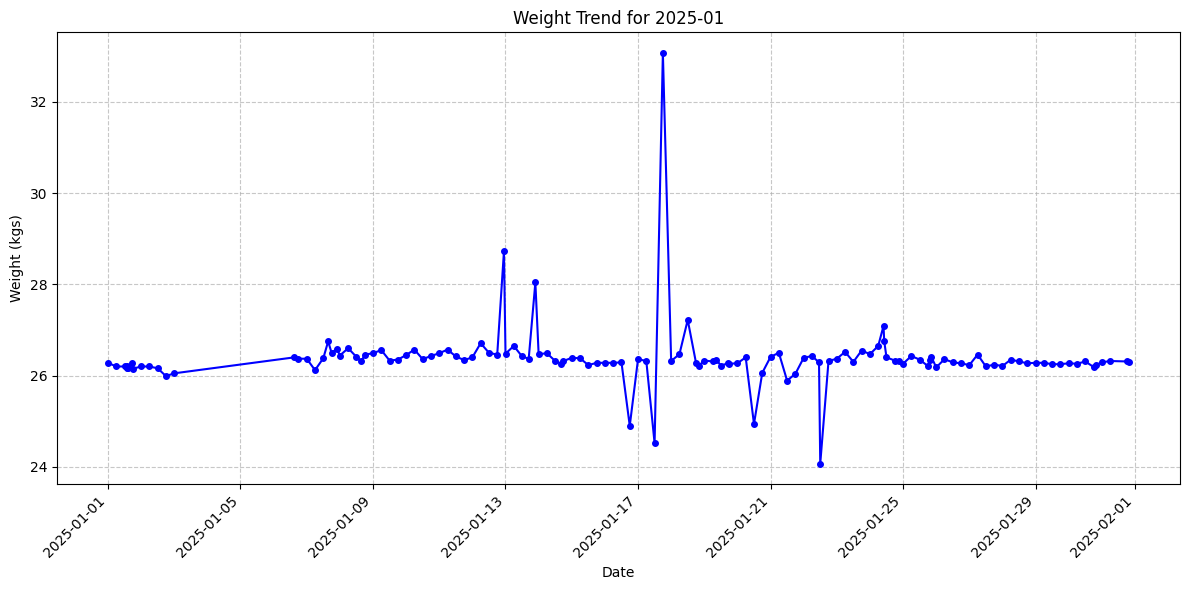

{'Year': 2025,
 'Month': 1,
 'Statistics': {'Maximum Weight': 33.07,
                'Minimum Weight': 24.07,
                'Mean Weight': 26.38},
 'Daily Weight Fluctuations': {'Significant Fluctuations': [{'fluctuation_range': 8.55},
                                                            {'fluctuation_range': 2.3599999999999994},
                                                            {'fluctuation_range': 2.3200000000000003},
                                                            {'fluctuation_range': 1.6699999999999982},
                                                            {'fluctuation_range': 1.4599999999999973},
                                                            {'fluctuation_range': 1.3900000000000006},
                                                            {'fluctuation_range': 1.009999999999998}],
                               'Fluctuations Summary': 'Most days show small '
                                                       'weight va

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
<ipython-input-57-9cac7c1d94ff>:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_trend = df_filtered.resample('H')['record'].mean()


In [58]:
results = analyze_weight_for_month_year(weights, 2025, 1)  # January 2025
print(results)

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pprint import pprint

def process_temperatures(df):
    """ Ensure datetime index and add year and month columns for filtering. """
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

def filter_by_year_month(df, year, month):
    """ Filter the DataFrame for a given year and month. """
    return df[(df['year'] == year) & (df['month'] == month)]

def plot_temperature_trends(df_filtered, year, month):
    """ Plot temperature trends for exterior and interior temperatures. """
    plt.figure(figsize=(12, 6))
    df_filtered[['Interior (°C)', 'Exterior (°C)']].plot(title=f"Temperature Trend for {year}-{month:02d}",
                                                          xlabel="Date", ylabel="Temperature (°C)", 
                                                          color=['r', 'b'], linestyle='-', marker='o', markersize=4)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def calculate_temperature_statistics(df_filtered):
    """ Calculate statistics: average, highest, and lowest temperatures. """
    avg_ext_temp = round(df_filtered['Exterior (°C)'].mean(), 1)
    max_ext_temp = round(df_filtered['Exterior (°C)'].max(), 1)
    min_ext_temp = round(df_filtered['Exterior (°C)'].min(), 1)

    avg_int_temp = round(df_filtered['Interior (°C)'].mean(), 1)
    max_int_temp = round(df_filtered['Interior (°C)'].max(), 1)
    min_int_temp = round(df_filtered['Interior (°C)'].min(), 1)

    return {
        "Exterior Temperatures": {"Lowest": min_ext_temp, "Highest": max_ext_temp, "Average": avg_ext_temp},
        "Interior Temperatures": {"Lowest": min_int_temp, "Highest": max_int_temp, "Average": avg_int_temp}
    }

def calculate_standard_deviation(df_filtered):
    """ Calculate standard deviation for both interior and exterior temperatures. """
    ext_temp_std = round(df_filtered['Exterior (°C)'].std(), 1)
    int_temp_std = round(df_filtered['Interior (°C)'].std(), 1)

    return {
        "Exterior": {"Standard Deviation": ext_temp_std},
        "Interior": {"Standard Deviation": int_temp_std}
    }

def correlation_analysis(df_filtered):
    """ Perform correlation analysis between interior and exterior temperatures. """
    corr, p_value = pearsonr(df_filtered['Interior (°C)'], df_filtered['Exterior (°C)'])
    return {
        "Correlation": {
            "Coefficient (r)": round(corr, 2),
            "p-value": round(p_value, 3),
            "Analysis": "A moderate positive correlation was observed between interior and exterior hive temperatures. "
                        "This indicates that external temperatures influence the hive's internal environment, "
                        "but the relationship is not perfectly linear, suggesting active thermoregulation by the colony."
        }
    }

def analyze_temperature_for_month_year(df, year, month):
    """ Complete pipeline to analyze temperature for a specific year and month. """
    # Step 1: Process data
    df = process_temperatures(df)

    # Step 2: Filter data for the specified month and year
    df_filtered = filter_by_year_month(df, year, month)

    if df_filtered.empty:
        return f"No data available for {year}-{month:02d}"

    # Step 3: Plot temperature trends
    plot_temperature_trends(df_filtered, year, month)

    # Step 4: Calculate temperature statistics
    temperature_stats = calculate_temperature_statistics(df_filtered)

    # Step 5: Calculate standard deviation
    std_devs = calculate_standard_deviation(df_filtered)

    # Step 6: Perform correlation analysis
    correlation = correlation_analysis(df_filtered)

    # Combine all the results into a final dictionary
    result = {
        "Year": year,
        "Month": month,
        "Temperature Statistics": temperature_stats,
        "Standard Deviation and Variability": std_devs,
        "Temperature Comparison": correlation
    }

    # Pretty-print the result
    pprint(result, sort_dicts=False)


<Figure size 1200x600 with 0 Axes>

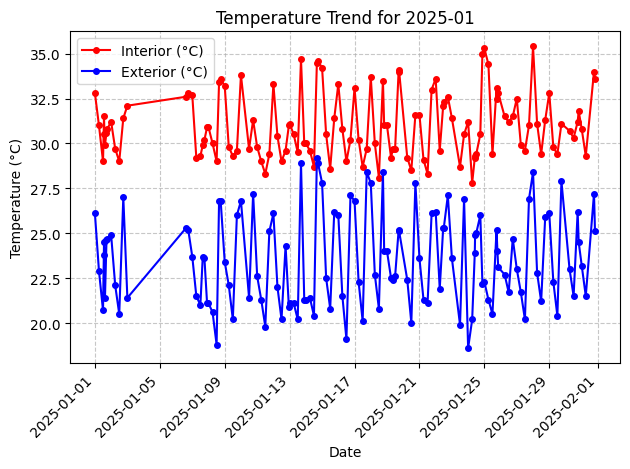

{'Year': 2025,
 'Month': 1,
 'Statistics': {'Exterior Temperatures': {'Lowest': 18.6,
                                          'Highest': 29.2,
                                          'Average': 23.5},
                'Interior Temperatures': {'Lowest': 27.8,
                                          'Highest': 35.4,
                                          'Average': 31.0}},
 'Standard Deviation and Variability': {'Exterior': {'Standard Deviation': 2.6,
                                                     'Analysis': 'The exterior '
                                                                 'temperature '
                                                                 'has wider '
                                                                 'fluctuations '
                                                                 'throughout '
                                                                 'the recorded '
                                                         

In [62]:
result = analyze_temperature_for_month_year(temperatures, 2025, 1)
print(result)